In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from cataclop.ml import preprocessing
from cataclop.ml import exploration

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [4]:
program.predict(dataset_params = {
    'from': '2016-01-01',
    'to': '2016-12-31',
    'categories': ['ATTELE']
}, model_params = {
    'kfolds': 3,
    'nan_flag': 100000,
    'n_targets': 4
})

preparing model data
preparing stacked model data


In [5]:
len(program.df)

31495

In [6]:
df = program.df

In [7]:
def bet(df, features, categorical_features, targets, N=1, max_odds=20, break_on_bet=True, break_on_odds=False):

    races = df.sort_values('start_at').groupby('race_id')

    bets = []

    for (id, race) in races:

        candidate_bets = []

        nums = []

        for target in targets:

            r = race.sort_values(by=target, ascending=False)

            if len(r) <= N:
                break
                
            NN = N

            for n in range(NN):

                player = r.iloc[n]

                odds = player['final_odds_ref']

                if max_odds is not None and odds > max_odds:
                    if break_on_odds:
                        break
                    else:
                        continue

                nth = (r['final_odds_ref']<odds).sum()+1
                
                #bet = np.clip(np.abs(player[target])/100.0, 0, 10)
                
                #bet = np.round(1+bet) * 1.5
                
                #if bet <= 0:
                #    break
                
                if n+1 < len(r) and r.iloc[n+1][target] == player[target]:
                    NN = NN+1
                    
                bet = 1

                profit = player['winner_dividend']/100.0 * bet - bet
                profit_placed = player['placed_dividend']/100.0 * bet - bet

                row = [id, player['start_at'], player['num'], player['position'], n, odds, player['final_odds'], target, player[target], r[target].std(), bet, profit, profit_placed]

                for nn in range(1,4):
                    if n+nn < len(r):
                        row.append(r.iloc[n+nn][target])
                    else:
                        row.append(np.nan)

                for f in features:
                    row.append(player[f])
                for f in categorical_features:
                    row.append(player[f])

                candidate_bets.append( row )

                nums.append(player['num'])

                if break_on_bet:
                    break

        #if len(candidate_bets) == 1:
        #    bets += candidate_bets
        bets += candidate_bets

    cols = ['id', 'date', 'num', 'pos', 'nb', 'odds_ref', 'odds_final', 'target', 'pred', 'pred_std', 'bet', 'profit', 'profit_placed']

    for nn in range(1,4):
        cols.append('next_pred_{}'.format(nn))

    cols = cols + features + categorical_features

    bets = pd.DataFrame(bets, columns=cols)
    bets['date'] = pd.to_datetime(bets['date'])

    bets = bets.set_index(bets['date'])
    bets = bets.sort_index()

    bets['bets'] = bets['bet'].cumsum()
    bets['stash'] = bets['profit'].cumsum()

    return bets



In [10]:
#exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'pred_stacked'] + ['pred_stacked_{}'.format(pos+1) for pos in range(1,8)] + ['pred_xgb_100_1', 'pred_rf_100_1', 'pred_knn_5_1', 'pred_mlp_100_1', 'pred_ridge_1_1']).sort_values(by='pred_stacked_8', ascending=False)
exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'target_pos', 'pred_xgb_100_1'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]).sort_values(by='position', ascending=True)



position  declared_player_count sub_category  num  final_odds  \
race_id                                                                        
30343   15905       1.0                     10    GROUPE_II    6         2.7   
        15903       2.0                     10    GROUPE_II    4         2.6   
        15904       3.0                     10    GROUPE_II    5         7.3   
        15900       4.0                     10    GROUPE_II    1         7.3   
        15901       5.0                     10    GROUPE_II    2        13.4   
        15908       6.0                     10    GROUPE_II    9        69.1   
        15902       7.0                     10    GROUPE_II    3        27.0   
        15907       8.0                     10    GROUPE_II    8        51.0   
        15906       9.0                     10    GROUPE_II    7        47.9   
        15909      10.0                     10    GROUPE_II   10       110.8   

               final_odds_ref  target_pos  pred_xgb_100_1  pred_xgb_10_1  \
race_id                                                                    
30343   15905             2.4         1.0        0.217237       0.193613   
        15903             3.0         2.0        0.185698       0.190759   
        15904             9.1         3.0        0.070526       0.150836   
        15900             7.6         4.0        0.093117       0.192567   
        15901            17.5         4.0        0.125084       0.172496   
        15908            38.9         4.0        0.027778       0.133915   
        15902            26.6         4.0        0.064773       0.146223   
        15907            29.9         4.0        0.041293       0.149013   
        15906            23.0         4.0        0.033730       0.137466   
        15909            81.9         4.0        0.018189       0.153215   

               pred_xgb_30_1  pred_xgb_100_1  pred_knn_5_1  pred_knn_10_1  \
race_id                                                                     
30343   15905       0.168422        0.217237      0.125776       0.159222   
        15903       0.151666        0.185698      0.132755       0.100517   
        15904       0.088131        0.070526      0.125876       0.067655   
        15900       0.138058        0.093117      0.115091       0.157239   
        15901       0.119213        0.125084      0.065296       0.065284   
        15908       0.063031        0.027778      0.000000       0.059842   
        15902       0.086210        0.064773      0.000000       0.033274   
        15907       0.072881        0.041293      0.066717       0.033772   
        15906       0.068814        0.033730      0.125572       0.125076   
        15909       0.066001        0.018189      0.000000       0.033126   

               pred_knn_20_1  pred_stacked_xgb_1  pred_stacked_mlp_sigmoid_1  \
race_id                                                                        
30343   15905       0.116219            0.899950                    1.599632   
        15903       0.051396            0.865061                    1.202850   
        15904       0.115174            0.866338                    0.782132   
        15900       0.086481            0.865907                    1.763092   
        15901       0.049856            0.809840                    0.712788   
        15908       0.032306            0.740939                   -0.461932   
        15902       0.049351            0.818012                   -0.471102   
        15907       0.049606            0.806894                   -0.715964   
        15906       0.085702            0.853338                    0.613347   
        15909       0.033506            0.650768                   -0.175455   

               pred_stacked_mlp_relu_1  
race_id                                 
30343   15905                 0.635153  
        15903                 0.755130  
        15904                 0.734322  
        15900                 0.738509  
        1

In [11]:
df = program.df
df['pred_rnd'] = np.random.rand(df.shape[0])
df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models ]].sum(axis=1)

for model in program.model.models:
    df['pred_{}_1_3'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(1,4) ] ].sum(axis=1)
    df['pred_{}_2_4'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(2,5) ] ].sum(axis=1)


for model in program.model.models:
    df['pred_minus_ref_{}'.format(model['name'])] = df['pred_{}_1'.format(model['name'])] - df['final_odds_ref']
    
for model in program.model.stacked_models:
    df['pred_minus_ref_stacked_{}'.format(model['name'])] = df['pred_stacked_{}_1'.format(model['name'])] - df['final_odds_ref']



bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_{}'.format(model['name'], i) for model in program.model.models for i in ['1_3', '2_4'] ] + ['pred_{}_{}'.format(model['name'], i+1) for i in range(program.model.params['n_targets']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models] 
   )

'''
bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]
   )
'''
    
    

"\nbets = bet(df, program.model.features, program.model.categorical_features, \n    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, \n    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]\n   )\n"

In [ ]:
program.df.race_id.nunique()

In [14]:
def graph_bb(bb, f):
    results = []

    for s in bb[f].value_counts().index:
        results = []
        x = bb[ (bb[f] == s) & (bb['pred_std'] != 0) & (bb['pred'] != 0) ].copy()
        if len(x) == 0:
            continue
        #print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))

        fig, axs = plt.subplots(1,1)

        for t in x['target'].value_counts().index:
            bbb = x[(x['target'] == t)].copy()
            #bbb = bbb[ (bbb['pred']>bbb['pred'].quantile(0.85)) ].copy()


            results.append({
                'idx_1': s,
                'idx_2': t,
                'profit': bbb.profit.sum(),
                'profit_place': bbb.profit_placed.sum(),
                'bet': bbb.bet.sum(),
                'bets': bbb.bet.count(),
                'avg': bbb.profit.sum() / bbb.bet.sum()
            })

            '''
            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            fig, axs = plt.subplots(1,1)
            bbb['stash'].plot(figsize=(6, 2))
            bbb['cbet'].plot(figsize=(6, 2))
            plt.show()
            '''

            #print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )

            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            bbb['stash'].plot(figsize=(10, 2))
            bbb['cbet'].plot(figsize=(10, 2))

        results = pd.DataFrame(results)
        results = results.set_index(['idx_1', 'idx_2'])
        print(results.sort_values(by='avg', ascending=False))


        plt.show()    

    
    

In [ ]:
#countries = list(bets['country'].value_counts()[0:10].index)
#sub_categories = list(bets['sub_category'].value_counts()[0:10].index)

#%store countries
#%store sub_categories

In [ ]:
%store -r params
%store -r countries
%store -r sub_categories

In [ ]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

target = 'final_odds_ref'

c_min = bets[(bets['target'] == target)]['pred'].min()
c_mean = bets[(bets['target'] == target)]['pred'].mean()
c_max = bets[(bets['target'] == target)]['pred'].max()

space = [
          Real(1, 10, name='min_odds'),
          Real(10, 30, name='max_odds'),
          Real(c_min, c_mean, name='min_pred'),
          Real(c_mean, c_max, name='max_pred'),
          Integer(5, 25, name='max_players')] + [
          Integer(0,1, name='country_{}'.format(country)) for country in countries] + [
          Integer(0,1, name='sub_category_{}'.format(sub_category)) for sub_category in sub_categories] + [
          Integer(0,1, name='nb_{}'.format(n)) for n in range(0,3)]
         
def x_to_params(x):
    params = {}
    
    params['min_odds'] = x[0]
    params['max_odds'] = x[1]
    params['max_pred'] = x[3]
    params['min_pred'] = x[2]
    params['max_players'] = x[4]
    
    for i, country in enumerate(countries):
        params['country_{}'.format(country)] = x[5+i]
        
    for i, sc in enumerate(sub_categories):
        params['sub_category_{}'.format(sc)] = x[5+len(countries)+i]
        
    for n in range(0,3):
        params['nb_{}'.format(n)] = x[5+len(countries)+len(sub_categories)+n]

    return params

@use_named_args(space)
def f(**params):
    return ff(params)
    
def ff(params, train=True):
    
    print(params)
    
    b = bets[ (bets['target']==target) & (bets['pred_std'] >= 0)]
    
    b = b[ (b['odds_ref'] > params['min_odds']) & (b['odds_ref'] < params['max_odds']) & (b['declared_player_count'] > 1) & (b['declared_player_count'] <= params['max_players']) ]
    
    b = b[(b['pred'] > params['min_pred']) & (b['pred'] < params['max_pred'])]
    
    for country in countries:
        if params['country_{}'.format(country)] == 0:
            b = b[ b['country'] != country ]
            
    for sub_category in sub_categories:
        if params['sub_category_{}'.format(sub_category)] == 0:
            b = b[ b['sub_category'] != sub_category ]
            
    for n in range(0,3):
        if params['nb_{}'.format(n)] == 0:
            b = b[ b['nb'] != n]
    
    p = b.profit.sum()
    bet = b.bet.sum()
    
    print("{:+.2f} {:+.2f}\n".format(p, bet))
        
    if bet == 0:
        return 0
    
    if not train:
        return b
    
    return - (p)
    
    

In [ ]:
#from skopt import dummy_minimize, gp_minimize, gbrt_minimize

#res = gbrt_minimize(f, space, n_calls=100)

In [ ]:
#print(res.x, res.fun)

In [ ]:
#params = x_to_params(res.x)
#%store params

In [ ]:
len(program.model.models[0]['estimators'])
program.model.hash

In [ ]:
bb = ff(params, False)

                                        avg  bet  bets  profit  profit_place
idx_1  idx_2                                                                
ATTELE pred_knn_10_1              -0.018195  665   665   -12.1        -128.2
       pred_knn_5_4               -0.025647  425   425   -10.9         -29.5
       pred_knn_20_1_3            -0.045455  671   671   -30.5         -53.4
       pred_stacked_mlp_sigmoid_1 -0.050803  498   498   -25.3         -82.2
       pred_knn_20_3              -0.064793  605   605   -39.2         -73.0
       pred_knn_20_2              -0.064977  651   651   -42.3         -36.6
       pred_knn_5_2               -0.091388  627   627   -57.3        -137.2
       pred_knn_5_1               -0.111433  656   656   -73.1         -76.4
       pred_sum                   -0.117827  718   718   -84.6        -121.7
       pred_xgb_30_2              -0.153426  788   788  -120.9        -110.8
       pred_xgb_10_3              -0.168502  781   781  -131.6        -109.3

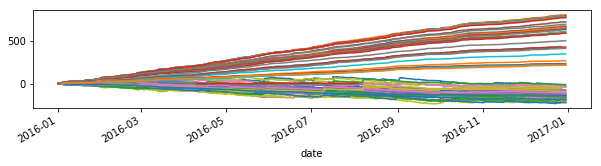

In [23]:
#bb = bets
bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='fNATIONALE_AUTOSTART') & (bets['nb']==0) & (bets['pred']>0) & (bets['target']!='fpred_stacked_mlp_sigmoid_1') & (bets['odds_ref']<20) & (bets['odds_ref']>3)  ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & (bets['odds_ref']>=bets['odds_1']) & (bets['odds_ref']<20) & (bets['target']!='psred_mlp_20_1') ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']=='AUTOSTART') & (bets['nb']<=0) & (bets['odds_ref']>=0) & (bets['odds_ref']<20) ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & ( (bets['target']=='pred_knn_10_1') | (bets['target']=='pred_minus_ref_lasso_1') ) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>20)].copy()        
#bb = bets[ (bets['country']=='FRA') & (bets['nb']==0) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>0)].copy()
#bb = bb.groupby('id').filter(lambda r: r['num'].count() == 2)
#graph_bb( bets[(bets['target']=='pred_lasso_0.1_1') & (bets['nb']==0) & (bets['odds_ref']>5) & (bets['odds_ref']<20) & (bets['pred']>0.)], 'sub_category')
#bb['profit'] = bb['profit'] * 1/(1+bb['nb'])
#bb['bet'] = bb['bet'] * 1/(1+bb['nb'])

#bb['profit'] = bb['profit'] * np.round(bb['pred']*100)
#bb['bet'] = bb['bet'] * np.round(bb['pred']*100)

graph_bb(bb, 'category')




In [ ]:
len(df[ (df['position']==1)  ])

In [ ]:
df['placed_3_count'].describe()

In [ ]:
bb